# Assignment 2

**Author:** Tingjun Yuan

## Preparation

Import necessary libraries:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

## Task 1

Prepare the model for the given dataset and evaluate it.

### Read the dataset from the files

**NOTE:** The following code assumes that `dataset.zip` from the assignment description page is unarchived as the directory `dataset`.

In [2]:
def build_data_list(path_prefix):
    data_mapping = {}
    for filename in os.listdir(path_prefix):
        scene_id = filename[:filename.find('.')]
        suffix = filename[filename.find('.')+1:]
        pair = data_mapping.setdefault(scene_id, {})
        match suffix:
            case 'edges':
                edges = pd.read_csv(
                    os.path.join(path_prefix, filename),
                    header=None,
                    names=['target', 'source']
                )
                edges = edges[(edges['target'] != -1) & (edges['source'] != -1)]
                edges['target'] = edges['target'].astype(int)
                edges['source'] = edges['source'].astype(int)
                pair['edges'] = edges
            case 'nodes':
                nodes = pd.read_csv(
                    os.path.join(path_prefix, filename),
                    header=None,
                    names=['node_id', 'current_x', 'current_y', 'previous_x',
                        'previous_y', 'future_x', 'future_y'],
                    na_values='_'
                )
                nodes['node_id'] = nodes['node_id'].astype(int)
                pair['nodes'] = nodes
            case _:
                raise AssertionError(f'Unexpected suffix {suffix}')
    
    # For simplicity, refine the scene id into a 0-based index. We can then store
    # the edges and nodes into a list:
    data_list = [pair for pair in data_mapping.values()]
    return data_list

data_list = build_data_list(path_prefix="dataset")

In [3]:
data_list[0]['edges']

,target,source
0,19585800,19590700
1,19591900,19592201
2,19591900,19595300
3,19591900,19595800
4,19592201,19595300
5,19592201,19595800
6,19592201,20000100
7,19595300,19595800
8,19595800,20000100
9,20000200,20000300


In [4]:
data_list[0]['nodes']

,node_id,current_x,current_y,previous_x,previous_y,future_x,future_y
0,19502500,40055.0,-16746.0,40071.0,-16621.0,40533.0,-17117.0
1,19585800,25369.0,-15783.0,24661.0,-15352.0,26397.0,-16549.0
2,19590700,25595.0,-15126.0,24826.0,-14669.0,26641.0,-15512.0
3,19591900,19436.0,-12565.0,18317.0,-12234.0,20411.0,-13030.0
4,19592201,21689.0,-13790.0,20970.0,-13362.0,22452.0,-14398.0
5,19592800,9014.0,1389.0,9283.0,1325.0,8961.0,1629.0
6,19595200,32100.0,-17434.0,30479.0,-16935.0,33987.0,-17862.0
7,19595300,19707.0,-12088.0,18260.0,-11553.0,20630.0,-12513.0
8,19595800,20630.0,-13866.0,19906.0,-13056.0,21536.0,-14176.0
9,20000100,23159.0,-13333.0,22106.0,-13541.0,NaN,NaN


### Split the dataset

Split the dataset into 70/30 train/test sets.

In [5]:
def split_dataset(data_list, random_seed=1231, train_set_size=0.7):
    #random.seed(random_seed)

    # Step 1: Shuffle scene indices
    shuffled_index = [i for i in range(len(data_list))]
    random.shuffle(shuffled_index)

    # Step 2: Split into training (default 70%) and test sets
    split_idx = int(train_set_size * len(data_list))
    train_ids = shuffled_index[:split_idx]
    test_ids = shuffled_index[split_idx:]

    # Step 3: Create two new lists for training and test sets
    train_set = [data_list[i] for i in train_ids]
    test_set = [data_list[i] for i in test_ids]

    return (train_set, test_set)

train_set, test_set = split_dataset(data_list)

print(f"The train dataset has {len(train_set)} scenes")
print(f"The test dataset has {len(test_set)} scenes")

The train dataset has 135 scenes
The test dataset has 58 scenes


### Prepare the graph data

In [6]:
def prepare_graph(dataset):
    all_edges = []
    all_node_features = []
    node_id_offset = 0  # Keeps track of global node indexing
    
    for scene in dataset:
        edges = scene['edges'].copy()
        nodes = scene['nodes'].copy()

        # Sort nodes to ensure consistent indexing
        nodes = nodes.sort_values('node_id').reset_index(drop=True)

        # Map node IDs to local 0-based indices
        node_id_map = {nid: i for i, nid in enumerate(nodes['node_id'])}

        # Apply mapping to edge list
        edges = edges[edges['source'].isin(node_id_map) & edges['target'].isin(node_id_map)]
        src = edges['source'].map(node_id_map).to_numpy() + node_id_offset
        tgt = edges['target'].map(node_id_map).to_numpy() + node_id_offset
        scene_edges = np.stack([src, tgt], axis=0)
        all_edges.append(scene_edges)

        # Node features (excluding node_id)
        node_feats = nodes.drop(columns=['node_id']).fillna(0.0).to_numpy()
        all_node_features.append(node_feats)

        node_id_offset += len(nodes)
    
    # Concatenate edges and features from all scenes
    edge_index = torch.tensor(np.hstack(all_edges), dtype=torch.int64)
    node_features = torch.tensor(np.vstack(all_node_features), dtype=torch.float)

    return (edge_index, node_features)

edge_index, node_features = prepare_graph(train_set)

print(f"Edge index shape:    {edge_index.shape}")
print(f"Node features shape: {node_features.shape}")

Edge index shape:    torch.Size([2, 2064])
Node features shape: torch.Size([1624, 6])


### Define classes for layers and training logic

In [7]:
class GraphAttention(nn.Module):
    def __init__(self, units, dropout=0.6, kernel_initializer="glorot_uniform"):
        super(GraphAttention, self).__init__()
        self.units = units
        self.dropout = nn.Dropout(dropout)
        self.kernel_initializer = kernel_initializer

        self.kernel = None
        self.kernel_attention = None
        self.built = False

    def build(self, input_dim, device):
        # Learnable weights
        self.kernel = nn.Parameter(torch.empty(input_dim, self.units, device=device))
        self.kernel_attention = nn.Parameter(torch.empty(self.units * 2, 1, device=device))

        # Initialization fix
        if self.kernel_initializer == "glorot_uniform":
            nn.init.xavier_uniform_(self.kernel)
            nn.init.xavier_uniform_(self.kernel_attention)
        else:
            nn.init.kaiming_uniform_(self.kernel, nonlinearity='leaky_relu')
            nn.init.kaiming_uniform_(self.kernel_attention, nonlinearity='leaky_relu')

        self.built = True

    def forward(self, node_states, edges):
        # Handle edge index shape: [2, E] -> [E, 2]
        if edges.dim() == 2 and edges.size(0) == 2:
            edges = edges.T

        if not self.built:
            self.build(node_states.size(1), node_states.device)

        # 1. Linear transformation
        node_states_transformed = torch.matmul(node_states, self.kernel)

        # 2. Attention scores
        # edges: [E, 2] -> pick each (src, tgt) feature pair
        edge_feat_src = node_states_transformed[edges[:, 0]]
        edge_feat_tgt = node_states_transformed[edges[:, 1]]
        edge_concat = torch.cat([edge_feat_src, edge_feat_tgt], dim=1)  # [E, 2*units]

        attention_scores = F.leaky_relu(torch.matmul(edge_concat, self.kernel_attention)).squeeze(-1)
        attention_scores = self.dropout(attention_scores)

        # 3. Normalize with softmax (per node src)
        attention_scores_clipped = torch.clamp(attention_scores, -2, 2)  # Stability
        attention_scores_exp = torch.exp(attention_scores_clipped)

        attention_sum = torch.zeros(node_states.size(0), device=node_states.device)
        attention_sum = attention_sum.index_add(0, edges[:, 0], attention_scores_exp)
        normalized_attention = attention_scores_exp / attention_sum[edges[:, 0]]

        # 4. Aggregate neighbor features
        neighbor_features = node_states_transformed[edges[:, 1]]
        weighted_neighbors = neighbor_features * normalized_attention.unsqueeze(1)

        out = torch.zeros_like(node_states_transformed)
        out = out.index_add(0, edges[:, 0], weighted_neighbors)

        return out

class MultiHeadGraphAttention(nn.Module):
    def __init__(self, units, num_heads=8, merge_type="concat", dropout=0.6):
        super(MultiHeadGraphAttention, self).__init__()
        self.num_heads = num_heads
        self.merge_type = merge_type

        self.attention_layers = nn.ModuleList([
            GraphAttention(units, dropout=dropout) for _ in range(num_heads)
        ])
        self.activation = nn.ReLU()  # Activation function set here!
        self.dropout = nn.Dropout(dropout)

    def forward(self, node_features, edges):
        # Process each head
        head_outputs = [att(node_features, edges) for att in self.attention_layers]

        # Merge heads
        if self.merge_type == "concat":
            out = torch.cat(head_outputs, dim=1)  # [N, units * num_heads]
        else:
            out = torch.mean(torch.stack(head_outputs, dim=0), dim=0)  # [N, units]

        return self.activation(self.dropout(out))

class GraphAttentionNetwork(nn.Module):
    def __init__(self, input_dim, hidden_units, num_heads, num_layers, output_dim, dropout=0.6):
        super(GraphAttentionNetwork, self).__init__()

        self.preprocess = nn.Linear(input_dim, hidden_units * num_heads)
        self.attention_layers = nn.ModuleList([
            MultiHeadGraphAttention(hidden_units, num_heads, merge_type="concat", dropout=dropout)
            for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(hidden_units * num_heads, output_dim)
        self.activation = nn.ReLU()

    def forward(self, node_states, edges):
        # 1. Preprocess input features
        x = self.activation(self.preprocess(node_states))

        # 2. Apply GAT layers with residual connections
        for att_layer in self.attention_layers:
            h = att_layer(x, edges)
            if h.shape == x.shape:
                x = h + x  # Residual connection only if shapes match
            else:
                x = h

        # 3. Final linear output
        return self.output_layer(x)

### Train and evaluate

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.mps.is_available():
    device = torch.device('mps')
elif torch.xpu.is_available():
    device = torch.device('xpu')
else:
    device = torch.device('cpu')

device

device(type='mps')

In [9]:
def train_and_evaluate_model(hidden_units, num_heads, num_layers,
                             output_dim, num_epochs, learning_rate,
                             device, train_set, test_set):
    def prepare_graph_and_targets(dataset):
        # Get full graph and node features
        edge_index, node_features = prepare_graph(dataset)
        node_features = node_features.to(device)
        edge_index = edge_index.to(device)

        # Normalize node features
        node_features = node_features / 10000.0

        # Prepare and normalize targets
        target_positions = []
        for scene in dataset:
            nodes = scene['nodes'].sort_values('node_id').reset_index(drop=True)
            future_xy = nodes[['future_x', 'future_y']].fillna(0.0).to_numpy()
            future_xy = future_xy / 10000.0  # Normalize here!
            target_positions.append(future_xy)
        y = torch.tensor(np.vstack(target_positions), dtype=torch.float, device=device)

        return (node_features, edge_index, y)

    # Step 1: Prepare train and test data
    x_train, edge_index_train, y_train = prepare_graph_and_targets(train_set)
    x_test, edge_index_test, y_test = prepare_graph_and_targets(test_set)

    # Step 2: Model and optimizer setup
    model = GraphAttentionNetwork(
        input_dim=x_train.size(1),
        hidden_units=hidden_units,
        num_heads=num_heads,
        num_layers=num_layers,
        output_dim=output_dim,
        dropout=0.6
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    print(f"Training for {num_epochs} epochs:")
    epoch_evaluations = []

    # Step 3: Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        preds = model(x_train, edge_index_train)
        if torch.isnan(preds).any() or torch.isinf(preds).any():
            raise RuntimeError(f"Predictions contain NaNs or Infs at epoch {epoch}")
        
        loss = loss_fn(preds, y_train)
        loss.backward()
        optimizer.step()

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_preds = model(x_test, edge_index_test)
            test_loss = torch.sqrt(((test_preds - y_test) ** 2).sum(dim=1)).mean()

        train_mse = loss.item()
        test_mean_euclidean_dist = test_loss.item()

        print(f"Epoch {epoch+1:3d} -- Train MSE: {train_mse:.4f}, Test Mean Euclidean Dist: {test_mean_euclidean_dist:.4f}")
        epoch_evaluations.append({
            'train_mse': train_mse,
            'test_mean_euclidean_dist': test_mean_euclidean_dist
        })

    return (model, epoch_evaluations)

In [10]:
model, epoch_evaluations = train_and_evaluate_model(
    hidden_units=100,
    num_heads=8,
    num_layers=3,
    output_dim=2,          # Predicting (future_x, future_y)
    num_epochs=100,
    learning_rate=1e-3,    # Stable with Adam
    device=device,
    train_set=train_set,
    test_set=test_set,
)

Training for 100 epochs:
Epoch   1 -- Train MSE: 14.9798, Test Mean Euclidean Dist: 3.2357
Epoch   2 -- Train MSE: 7.5262, Test Mean Euclidean Dist: 2.3041
Epoch   3 -- Train MSE: 4.7180, Test Mean Euclidean Dist: 1.6262
Epoch   4 -- Train MSE: 3.7329, Test Mean Euclidean Dist: 1.9017
Epoch   5 -- Train MSE: 4.4762, Test Mean Euclidean Dist: 2.2474
Epoch   6 -- Train MSE: 5.2196, Test Mean Euclidean Dist: 2.3689
Epoch   7 -- Train MSE: 5.8009, Test Mean Euclidean Dist: 2.2689
Epoch   8 -- Train MSE: 5.6897, Test Mean Euclidean Dist: 2.0127
Epoch   9 -- Train MSE: 4.5706, Test Mean Euclidean Dist: 1.6996
Epoch  10 -- Train MSE: 3.5692, Test Mean Euclidean Dist: 1.3887
Epoch  11 -- Train MSE: 2.9407, Test Mean Euclidean Dist: 1.1572
Epoch  12 -- Train MSE: 2.5366, Test Mean Euclidean Dist: 1.2049
Epoch  13 -- Train MSE: 2.3796, Test Mean Euclidean Dist: 1.4326
Epoch  14 -- Train MSE: 2.4222, Test Mean Euclidean Dist: 1.6398
Epoch  15 -- Train MSE: 2.8231, Test Mean Euclidean Dist: 1.7548

### Visualize the prediction

First, randomly choose 2 different indices of scenes. We will use the same test scenes in the future to test.

In [11]:
selected_indices = set()
while len(selected_indices) < 2:
    selected_indices.add(random.randint(0, len(test_set) - 1))
selected_scenes = [test_set[i] for i in selected_indices]

In [12]:
def visualize_predictions(model, scene, device, scale=10000.0, title_suffix=""):
    # 1. Prepare the scene
    nodes = scene['nodes'].sort_values('node_id').reset_index(drop=True)
    edges = scene['edges']

    # 2. Prepare inputs
    node_feats = nodes.drop(columns=['node_id']).fillna(0.0).to_numpy() / scale
    future_xy_true = nodes[['future_x', 'future_y']].fillna(0.0).to_numpy() / scale

    node_feats = torch.tensor(node_feats, dtype=torch.float, device=device)
    edges_tensor = torch.tensor(edges[['source', 'target']].to_numpy().T, dtype=torch.long, device=device)

    # 3. Predict
    model.eval()
    with torch.no_grad():
        preds = model(node_feats, edges_tensor)

    # 4. Denormalize
    predicted_xy = preds.cpu().numpy() * scale
    true_xy = future_xy_true * scale

    # 5. Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(true_xy[:, 0], true_xy[:, 1], color='green', label='True Future Position', alpha=0.7)
    plt.scatter(predicted_xy[:, 0], predicted_xy[:, 1], color='red', label='Predicted Position', marker='x')
    
    for i in range(len(true_xy)):
        plt.plot([true_xy[i, 0], predicted_xy[i, 0]],
                 [true_xy[i, 1], predicted_xy[i, 1]],
                 color='gray', linestyle='-', alpha=0.3)

    plt.title('Predicted vs. True Future Positions' +
              (f' ({title_suffix})' if title_suffix != '' else ''))
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

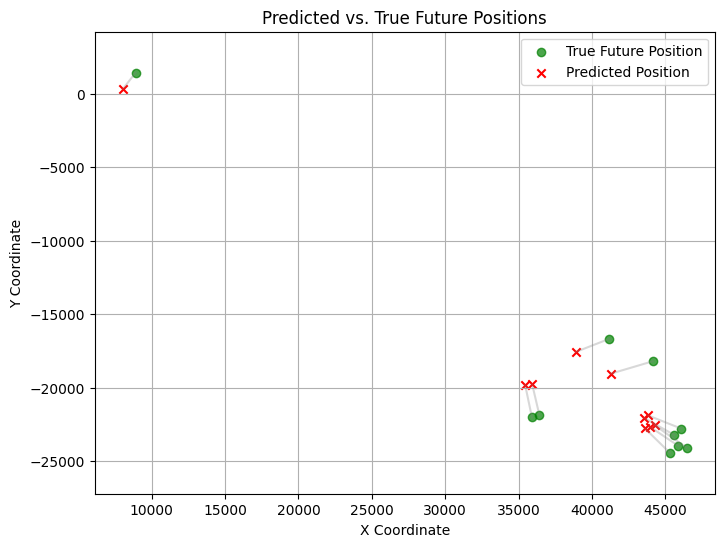

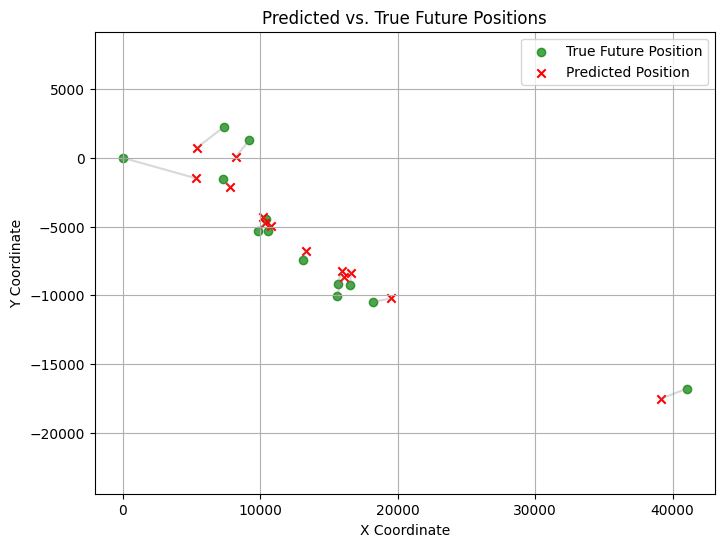

In [13]:
for scene in selected_scenes:
    visualize_predictions(model, scene, device)

## Task 2

Perform hyperparameter tuning of the number of attention heads and try a deeper embedding of the node features.

### Tuning of the number of attention heads

In [14]:
model_1, _ = train_and_evaluate_model(
    hidden_units=100,
    num_heads=32,        # This was changed
    num_layers=3,
    output_dim=2,
    num_epochs=100,
    learning_rate=1e-3,
    device=device,
    train_set=train_set,
    test_set=test_set,
)

Training for 100 epochs:
Epoch   1 -- Train MSE: 6.9650, Test Mean Euclidean Dist: 5.0287
Epoch   2 -- Train MSE: 26.3548, Test Mean Euclidean Dist: 2.5096
Epoch   3 -- Train MSE: 6.6970, Test Mean Euclidean Dist: 2.7086
Epoch   4 -- Train MSE: 6.3827, Test Mean Euclidean Dist: 4.1913
Epoch   5 -- Train MSE: 13.8032, Test Mean Euclidean Dist: 3.5311
Epoch   6 -- Train MSE: 9.9799, Test Mean Euclidean Dist: 1.7393
Epoch   7 -- Train MSE: 3.6385, Test Mean Euclidean Dist: 1.3663
Epoch   8 -- Train MSE: 2.9793, Test Mean Euclidean Dist: 2.3761
Epoch   9 -- Train MSE: 6.6684, Test Mean Euclidean Dist: 2.5684
Epoch  10 -- Train MSE: 7.4556, Test Mean Euclidean Dist: 1.9454
Epoch  11 -- Train MSE: 5.1683, Test Mean Euclidean Dist: 0.8724
Epoch  12 -- Train MSE: 1.9895, Test Mean Euclidean Dist: 1.0556
Epoch  13 -- Train MSE: 2.2239, Test Mean Euclidean Dist: 1.8699
Epoch  14 -- Train MSE: 4.5220, Test Mean Euclidean Dist: 2.0164
Epoch  15 -- Train MSE: 4.7798, Test Mean Euclidean Dist: 1.537

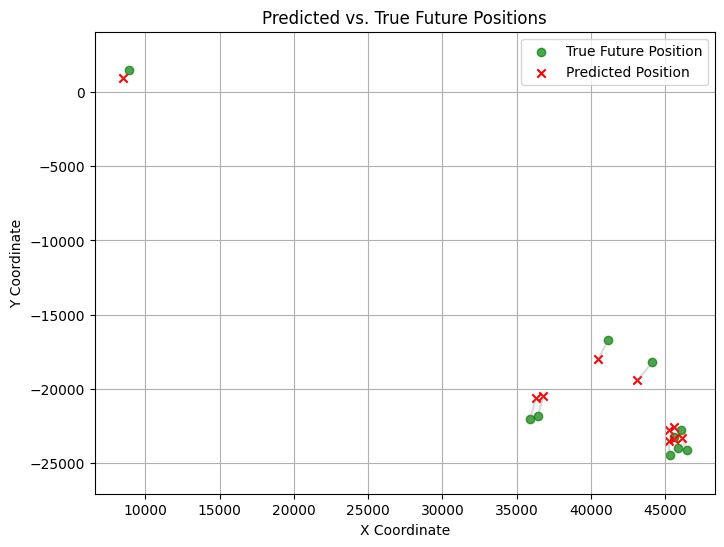

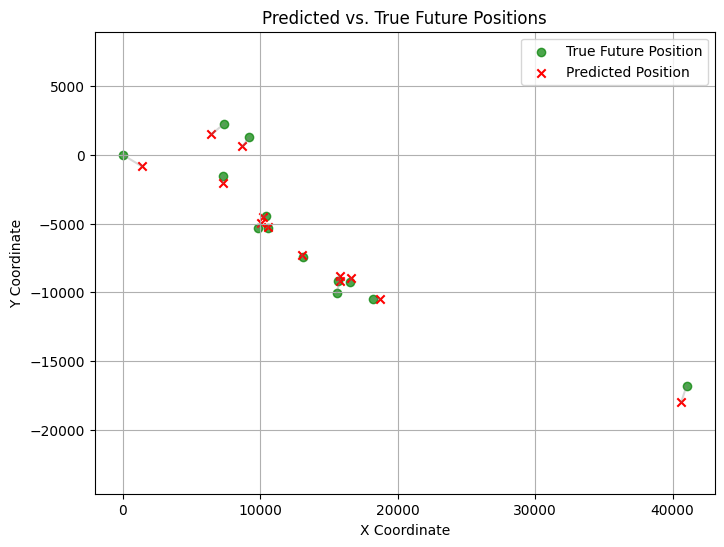

In [15]:
for scene in selected_scenes:
    visualize_predictions(model_1, scene, device)

In [16]:
model_2, _ = train_and_evaluate_model(
    hidden_units=100,
    num_heads=4,        # This was changed
    num_layers=3,
    output_dim=2,
    num_epochs=100,
    learning_rate=1e-3,
    device=device,
    train_set=train_set,
    test_set=test_set,
)

Training for 100 epochs:
Epoch   1 -- Train MSE: 4.0283, Test Mean Euclidean Dist: 1.5029
Epoch   2 -- Train MSE: 3.0618, Test Mean Euclidean Dist: 1.5439
Epoch   3 -- Train MSE: 3.0240, Test Mean Euclidean Dist: 1.6975
Epoch   4 -- Train MSE: 3.0504, Test Mean Euclidean Dist: 1.6584
Epoch   5 -- Train MSE: 2.9730, Test Mean Euclidean Dist: 1.5099
Epoch   6 -- Train MSE: 2.7202, Test Mean Euclidean Dist: 1.3484
Epoch   7 -- Train MSE: 2.4587, Test Mean Euclidean Dist: 1.2285
Epoch   8 -- Train MSE: 2.2804, Test Mean Euclidean Dist: 1.1667
Epoch   9 -- Train MSE: 2.1177, Test Mean Euclidean Dist: 1.1312
Epoch  10 -- Train MSE: 1.9862, Test Mean Euclidean Dist: 1.1007
Epoch  11 -- Train MSE: 2.0818, Test Mean Euclidean Dist: 1.0635
Epoch  12 -- Train MSE: 1.7711, Test Mean Euclidean Dist: 1.0131
Epoch  13 -- Train MSE: 1.6990, Test Mean Euclidean Dist: 0.9626
Epoch  14 -- Train MSE: 1.6520, Test Mean Euclidean Dist: 0.9198
Epoch  15 -- Train MSE: 1.4642, Test Mean Euclidean Dist: 0.8769


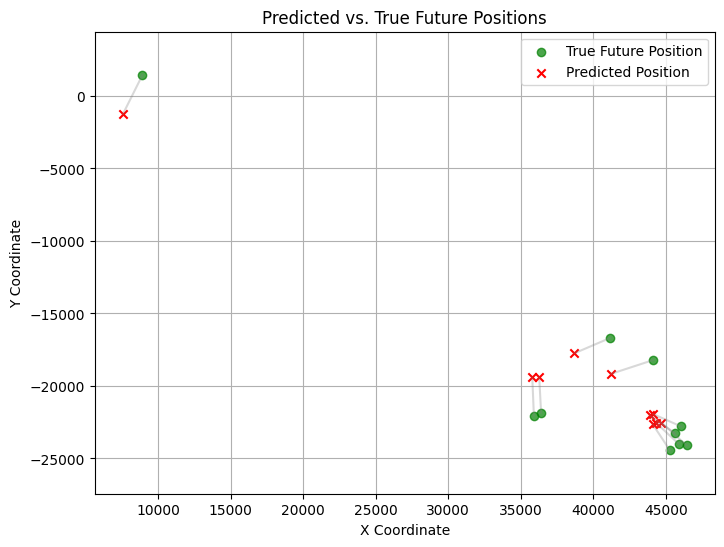

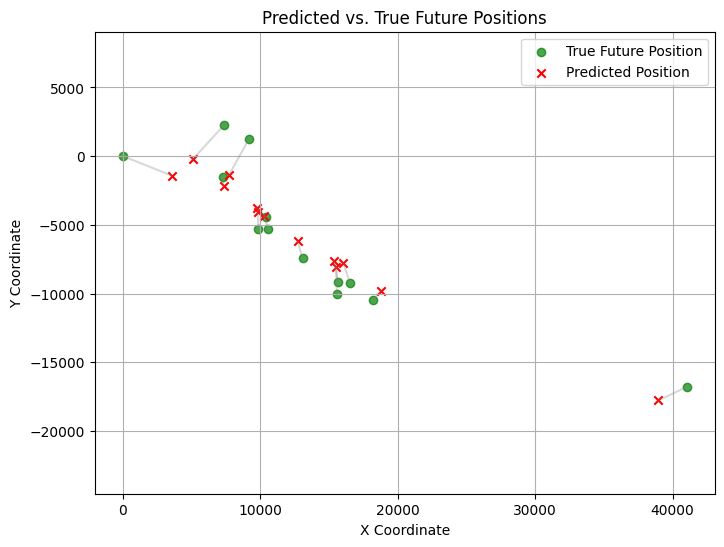

In [17]:
for scene in selected_scenes:
    visualize_predictions(model_2, scene, device)

In [18]:
model_3, _ = train_and_evaluate_model(
    hidden_units=100,
    num_heads=16,        # This was changed
    num_layers=3,
    output_dim=2,
    num_epochs=100,
    learning_rate=1e-3,
    device=device,
    train_set=train_set,
    test_set=test_set,
)

Training for 100 epochs:
Epoch   1 -- Train MSE: 8.8300, Test Mean Euclidean Dist: 2.1128
Epoch   2 -- Train MSE: 4.7302, Test Mean Euclidean Dist: 2.7503
Epoch   3 -- Train MSE: 6.8142, Test Mean Euclidean Dist: 2.1194
Epoch   4 -- Train MSE: 4.3888, Test Mean Euclidean Dist: 1.2012
Epoch   5 -- Train MSE: 2.7915, Test Mean Euclidean Dist: 1.7254
Epoch   6 -- Train MSE: 3.5395, Test Mean Euclidean Dist: 2.0314
Epoch   7 -- Train MSE: 4.0318, Test Mean Euclidean Dist: 1.7145
Epoch   8 -- Train MSE: 3.3785, Test Mean Euclidean Dist: 1.0153
Epoch   9 -- Train MSE: 2.2484, Test Mean Euclidean Dist: 0.8450
Epoch  10 -- Train MSE: 1.8076, Test Mean Euclidean Dist: 1.2355
Epoch  11 -- Train MSE: 2.3854, Test Mean Euclidean Dist: 1.3598
Epoch  12 -- Train MSE: 2.7997, Test Mean Euclidean Dist: 1.1594
Epoch  13 -- Train MSE: 2.4844, Test Mean Euclidean Dist: 0.7353
Epoch  14 -- Train MSE: 1.5744, Test Mean Euclidean Dist: 0.4803
Epoch  15 -- Train MSE: 1.4909, Test Mean Euclidean Dist: 0.7808


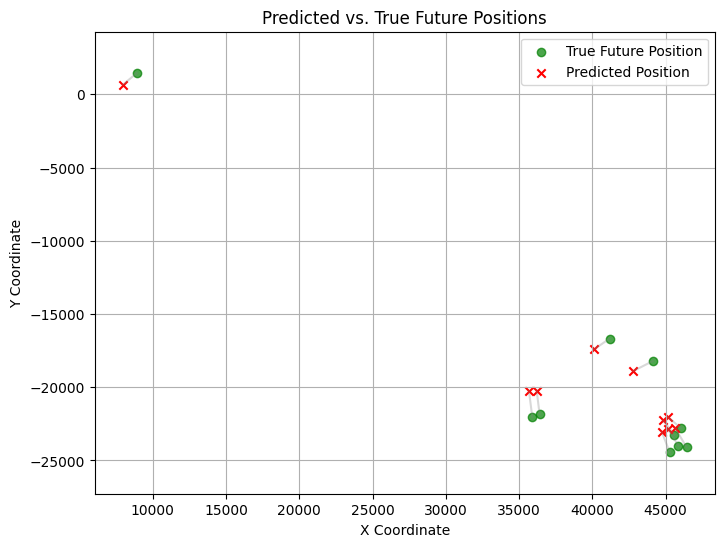

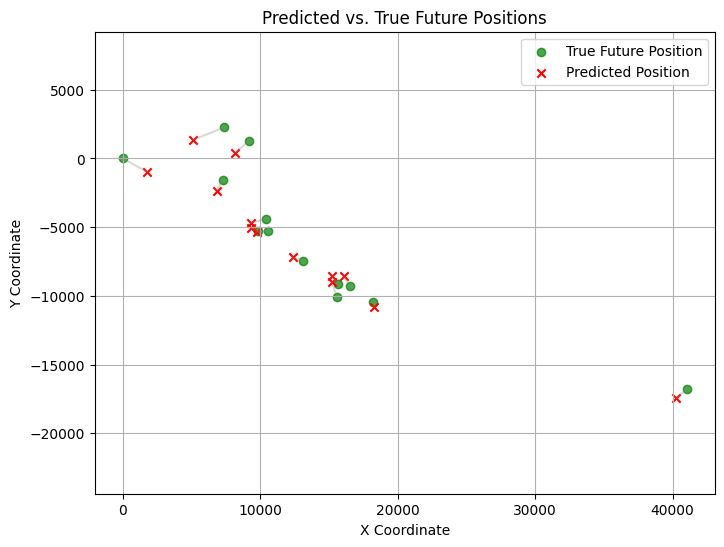

In [19]:
for scene in selected_scenes:
    visualize_predictions(model_3, scene, device)

### Trying a deeper embedding of the node features

To examine this, I rewrote the `GraphAttention` class and modify it to add one fully connected layer with ReLU activation and one additional fully connected layer.

In [20]:
class GraphAttention(nn.Module):
    def __init__(self, units, dropout=0.6, kernel_initializer="glorot_uniform", hidden_dim=None):
        super(GraphAttention, self).__init__()
        self.units = units
        self.dropout = nn.Dropout(dropout)
        self.kernel_initializer = kernel_initializer
        self.hidden_dim = hidden_dim or units

        self.fc1 = None
        self.fc2 = None
        self.kernel_attention = None
        self.built = False

    def build(self, input_dim, device):
        # MLP for node transformation
        self.fc1 = nn.Linear(input_dim, self.hidden_dim).to(device)
        self.fc2 = nn.Linear(self.hidden_dim, self.units).to(device)

        # Attention kernel (remains the same)
        self.kernel_attention = nn.Parameter(torch.empty(self.units * 2, 1, device=device))

        if self.kernel_initializer == "glorot_uniform":
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.kernel_attention)
        else:
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.kernel_attention, nonlinearity='leaky_relu')

        self.built = True

    def forward(self, node_states, edges):
        # Handle edge index shape: [2, E] -> [E, 2]
        if edges.dim() == 2 and edges.size(0) == 2:
            edges = edges.T

        if not self.built:
            self.build(node_states.size(1), node_states.device)

        # 1. MLP instead of linear
        x = F.relu(self.fc1(node_states))
        node_states_transformed = self.fc2(x)

        # 2. Attention scores (unchanged)
        # edges: [E, 2] -> pick each (src, tgt) feature pair
        edge_feat_src = node_states_transformed[edges[:, 0]]
        edge_feat_tgt = node_states_transformed[edges[:, 1]]
        edge_concat = torch.cat([edge_feat_src, edge_feat_tgt], dim=1)  # [E, 2*units]

        attention_scores = F.leaky_relu(torch.matmul(edge_concat, self.kernel_attention)).squeeze(-1)
        attention_scores = self.dropout(attention_scores)

        # 3. Normalize with softmax (per node src) (unchanged)
        attention_scores_clipped = torch.clamp(attention_scores, -2, 2)  # Stability
        attention_scores_exp = torch.exp(attention_scores_clipped)

        attention_sum = torch.zeros(node_states.size(0), device=node_states.device)
        attention_sum = attention_sum.index_add(0, edges[:, 0], attention_scores_exp)
        normalized_attention = attention_scores_exp / attention_sum[edges[:, 0]]

        # 4. Aggregate neighbor features (unchanged)
        neighbor_features = node_states_transformed[edges[:, 1]]
        weighted_neighbors = neighbor_features * normalized_attention.unsqueeze(1)

        out = torch.zeros_like(node_states_transformed)
        out = out.index_add(0, edges[:, 0], weighted_neighbors)

        return out

Now, retrain the model, using the same parameters as in Task 1:

In [21]:
model, epoch_evaluations = train_and_evaluate_model(
    hidden_units=100,
    num_heads=8,
    num_layers=3,
    output_dim=2,
    num_epochs=100,
    learning_rate=1e-3,
    device=device,
    train_set=train_set,
    test_set=test_set,
)

Training for 100 epochs:
Epoch   1 -- Train MSE: 6.8307, Test Mean Euclidean Dist: 2.3949
Epoch   2 -- Train MSE: 3.9808, Test Mean Euclidean Dist: 1.4770
Epoch   3 -- Train MSE: 1.8429, Test Mean Euclidean Dist: 1.0977
Epoch   4 -- Train MSE: 1.2643, Test Mean Euclidean Dist: 1.4894
Epoch   5 -- Train MSE: 1.8679, Test Mean Euclidean Dist: 1.7091
Epoch   6 -- Train MSE: 2.4798, Test Mean Euclidean Dist: 1.7274
Epoch   7 -- Train MSE: 2.4838, Test Mean Euclidean Dist: 1.6277
Epoch   8 -- Train MSE: 2.3110, Test Mean Euclidean Dist: 1.4768
Epoch   9 -- Train MSE: 2.0051, Test Mean Euclidean Dist: 1.2810
Epoch  10 -- Train MSE: 1.5719, Test Mean Euclidean Dist: 1.0351
Epoch  11 -- Train MSE: 1.0968, Test Mean Euclidean Dist: 0.7813
Epoch  12 -- Train MSE: 0.8304, Test Mean Euclidean Dist: 0.6935
Epoch  13 -- Train MSE: 0.8014, Test Mean Euclidean Dist: 0.8364
Epoch  14 -- Train MSE: 0.8977, Test Mean Euclidean Dist: 1.0098
Epoch  15 -- Train MSE: 1.0841, Test Mean Euclidean Dist: 1.0896


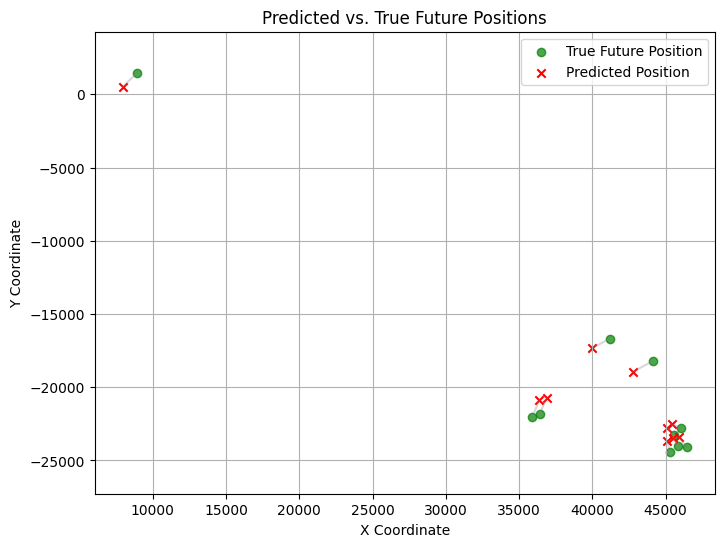

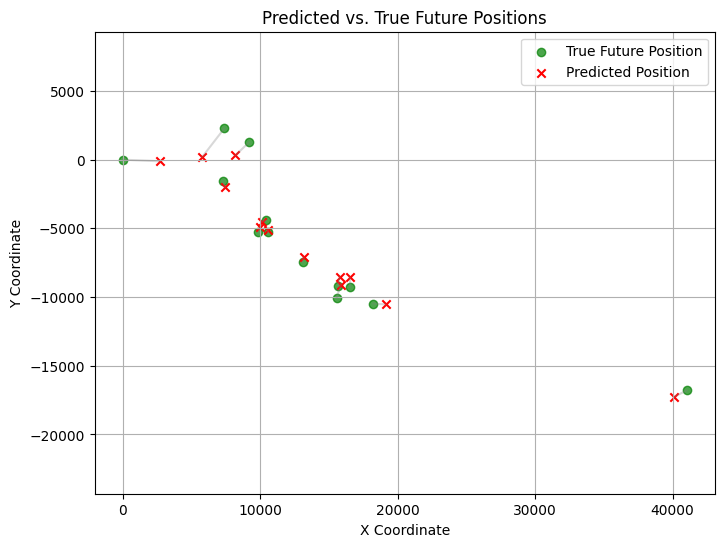

In [22]:
for scene in selected_scenes:
    visualize_predictions(model, scene, device)

## Task 3

Replace the learned attention mechanism with an attention mechanism based on the Cosine similarity between node vectors.

In [23]:
class CosineGraphAttention(nn.Module):
    def __init__(self, units, dropout=0.6, hidden_dim=None):
        super(CosineGraphAttention, self).__init__()
        self.units = units
        self.dropout = nn.Dropout(dropout)
        self.hidden_dim = hidden_dim or units

        self.fc1 = None
        self.fc2 = None
        self.built = False

    def build(self, input_dim, device):
        self.fc1 = nn.Linear(input_dim, self.hidden_dim).to(device)
        self.fc2 = nn.Linear(self.hidden_dim, self.units).to(device)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.built = True

    def forward(self, node_states, edges):
        if edges.dim() == 2 and edges.size(0) == 2:
            edges = edges.T

        if not self.built:
            self.build(node_states.size(1), node_states.device)

        # Step 1: Node embedding (MLP)
        x = F.relu(self.fc1(node_states))
        node_states_transformed = self.fc2(x)

        # Step 2: Get edge pairs
        src = edges[:, 0]
        tgt = edges[:, 1]
        node_i = node_states_transformed[src]
        node_j = node_states_transformed[tgt]

        # Step 3: Cosine similarity attention
        cosine_sim = F.cosine_similarity(node_i, node_j, dim=1)  # Shape: [E]
        cosine_sim = self.dropout(cosine_sim)

        # Step 4: Normalize attention weights (softmax over source nodes)
        cosine_sim_clipped = torch.clamp(cosine_sim, -1, 1)
        att_exp = torch.exp(cosine_sim_clipped)

        attention_sum = torch.zeros(node_states.size(0), device=node_states.device)
        attention_sum = attention_sum.index_add(0, src, att_exp)
        normalized_attention = att_exp / attention_sum[src]

        # Step 5: Aggregate weighted neighbors
        weighted_neighbors = node_j * normalized_attention.unsqueeze(1)
        out = torch.zeros_like(node_states_transformed)
        out = out.index_add(0, src, weighted_neighbors)

        return out

In [24]:
# Assign GraphAttention to CosineGraphAttention to suit MultiHeadGraphAttention
GraphAttention = CosineGraphAttention

model, epoch_evaluations = train_and_evaluate_model(
    hidden_units=100,
    num_heads=8,
    num_layers=3,
    output_dim=2,
    num_epochs=100,
    learning_rate=1e-3,
    device=device,
    train_set=train_set,
    test_set=test_set,
)

Training for 100 epochs:
Epoch   1 -- Train MSE: 4.5536, Test Mean Euclidean Dist: 1.6630
Epoch   2 -- Train MSE: 2.6722, Test Mean Euclidean Dist: 1.4402
Epoch   3 -- Train MSE: 2.2988, Test Mean Euclidean Dist: 1.6059
Epoch   4 -- Train MSE: 2.4691, Test Mean Euclidean Dist: 1.6574
Epoch   5 -- Train MSE: 2.3369, Test Mean Euclidean Dist: 1.5524
Epoch   6 -- Train MSE: 2.1860, Test Mean Euclidean Dist: 1.2933
Epoch   7 -- Train MSE: 1.7171, Test Mean Euclidean Dist: 0.9550
Epoch   8 -- Train MSE: 1.3970, Test Mean Euclidean Dist: 0.7924
Epoch   9 -- Train MSE: 1.1840, Test Mean Euclidean Dist: 0.9772
Epoch  10 -- Train MSE: 1.2397, Test Mean Euclidean Dist: 1.0799
Epoch  11 -- Train MSE: 1.2575, Test Mean Euclidean Dist: 1.0615
Epoch  12 -- Train MSE: 1.1741, Test Mean Euclidean Dist: 0.9625
Epoch  13 -- Train MSE: 1.0885, Test Mean Euclidean Dist: 0.8198
Epoch  14 -- Train MSE: 0.8634, Test Mean Euclidean Dist: 0.6780
Epoch  15 -- Train MSE: 0.8209, Test Mean Euclidean Dist: 0.5565


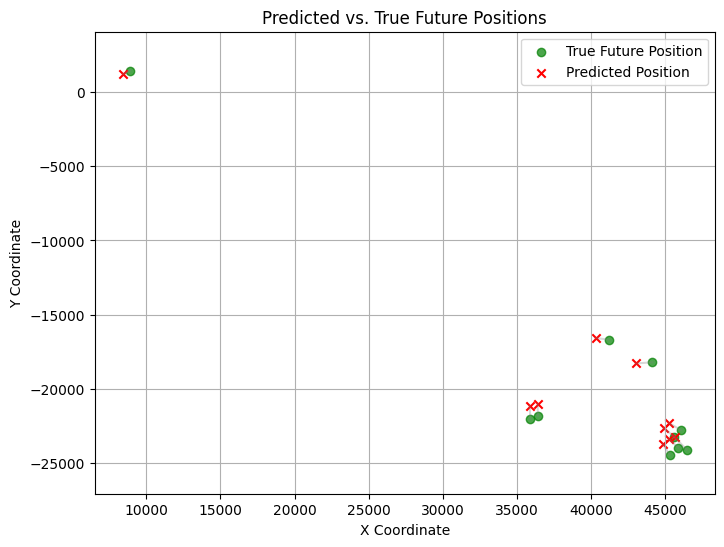

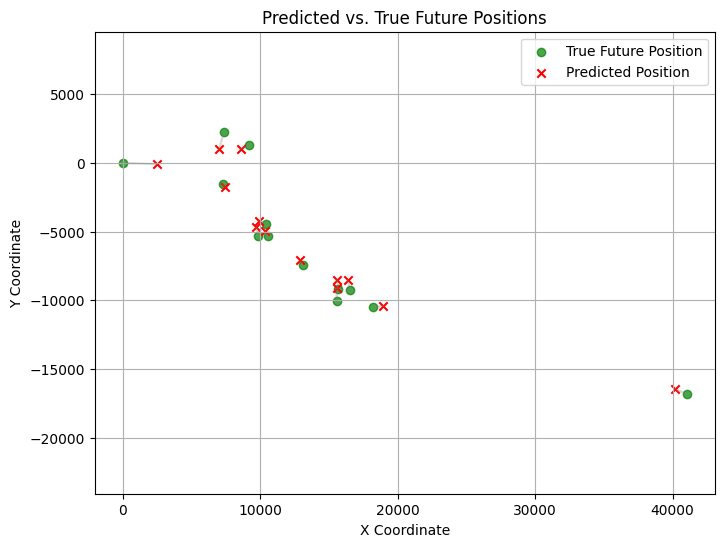

In [25]:
for scene in selected_scenes:
    visualize_predictions(model, scene, device)

## References

* https://keras.io/examples/graph/gat_node_classification/